In [3]:
import xarray as xr

In [13]:
%ls

dask-worker-space/         load_data.ipynb       monthly_era5_2018_subset.nc
Feature_Engineering.ipynb  monthly_era5_2018.nc


In [14]:
dset = xr.open_dataset('monthly_era5_2018_subset.nc')

In [15]:
dset.head()

<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 5, time: 5)
Coordinates:
  * longitude  (longitude) float32 5.0 5.25 5.5 5.75 6.0
  * latitude   (latitude) float32 45.0 44.75 44.5 44.25 44.0
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-05-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-17 19:06:25 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [16]:
stacked = dset['t2m'].stack(gridcell=['latitude', 'longitude'])

In [17]:
stacked

<xarray.DataArray 't2m' (time: 12, gridcell: 441)>
array([[280.49893, 278.94232, 277.1105 , ..., 282.80347, 285.7901 ,
        287.37622],
       [275.3462 , 274.0024 , 272.59448, ..., 279.34012, 282.90106,
        284.6001 ],
       [281.0806 , 279.73907, 277.88965, ..., 282.6548 , 285.24704,
        286.70377],
       ...,
       [286.8252 , 285.27426, 284.06723, ..., 289.31702, 292.36212,
        294.1122 ],
       [282.2286 , 281.07434, 279.50412, ..., 285.22092, 288.65817,
        290.49625],
       [279.0683 , 277.91574, 276.55096, ..., 282.8182 , 286.64246,
        288.25412]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
  * gridcell   (gridcell) MultiIndex
  - latitude   (gridcell) float64 45.0 45.0 45.0 45.0 ... 40.0 40.0 40.0 40.0
  - longitude  (gridcell) float64 5.0 5.25 5.5 5.75 6.0 ... 9.25 9.5 9.75 10.0
Attributes:
    units:      K
    long_name:  2 metre temperature

In [18]:
group = stacked.groupby("gridcell")

In [19]:
def minimum(x):
    return min(x)

In [20]:
test = group.apply(minimum).unstack('gridcell')

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [21]:
group

DataArrayGroupBy, grouped over 'gridcell' 
441 groups with labels (45.0,, 5.0), ..., (40.0,, 10.0).

In [1]:
#This was taking too long, so I'm going to integrate instead with Dask.
from dask.diagnostics import ProgressBar
import xarray.ufuncs as xu
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
client = Client()

/home/dyllanjr/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36109 instead
  warnings.warn(


In [4]:
ds = xr.open_dataset('monthly_era5_2018.nc', engine='scipy')

In [5]:
ds.attrs = {}
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...

In [6]:
ds.nbytes * (2 ** -30) #Shows size of dataset in Gb

0.09283402934670448

In [7]:
# convert from Kelvin to degrees Fahrenheit
%time 9 / 5.0 * (ds - 273.15) + 32

CPU times: user 250 ms, sys: 339 ms, total: 589 ms
Wall time: 544 ms


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 12)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
Data variables:
    t2m        (time, latitude, longitude) float32 -13.275864 ... -10.883732
    tp         (time, latitude, longitude) float32 -459.66965 ... -459.66937

In [8]:
%time float(ds.t2m.mean())

CPU times: user 74 ms, sys: 16.4 ms, total: 90.5 ms
Wall time: 85.1 ms


279.0191955566406

In [9]:
#Now lets see how dask performs.
ds = xr.open_dataset('monthly_era5_2018.nc', 
                     chunks={'time': -1, 'latitude': 10, 'longitude': 10})
%time 9 / 5.0 * (ds.t2m - 273.15) + 32

CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 6.45 ms


,Array,Chunk
Bytes,49.84 MB,4.80 kB
Shape,"(12, 721, 1440)","(12, 10, 10)"
Count,42049 Tasks,10512 Chunks
Type,float32,numpy.ndarray


In [10]:
%time ds.t2m.mean()

CPU times: user 76.4 ms, sys: 16.1 ms, total: 92.5 ms
Wall time: 89.2 ms


<xarray.DataArray 't2m' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [11]:
import dask
dask.config.get('array.chunk-size')

'128MiB'

This is an example:

In [12]:
%%time
# everything is fast until we compute values
ds_by_season = ds.groupby('time.season').mean('time')
t2m_range = abs(ds_by_season.sel(season='JJA')
                - ds_by_season.sel(season='DJF')).t2m

CPU times: user 2.93 s, sys: 193 ms, total: 3.13 s
Wall time: 3.08 s


In [13]:
# now we calculate the actual result
%time result = t2m_range.load()

CPU times: user 1min 1s, sys: 3.44 s, total: 1min 5s
Wall time: 1min 7s


In [15]:
result

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[22.088577, 22.088577, 22.088577, ..., 22.088577, 22.088577,
        22.088577],
       [21.852615, 21.852066, 21.852066, ..., 21.854813, 21.853165,
        21.853165],
       [21.605179, 21.60408 , 21.605728, ..., 21.610077, 21.60791 ,
        21.605728],
       ...,
       [20.80278 , 20.798965, 20.796219, ..., 20.807129, 20.804428,
        20.80333 ],
       [20.68097 , 20.678253, 20.676605, ..., 20.683151, 20.683151,
        20.682053],
       [20.89508 , 20.89508 , 20.89508 , ..., 20.89508 , 20.89508 ,
        20.89508 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75

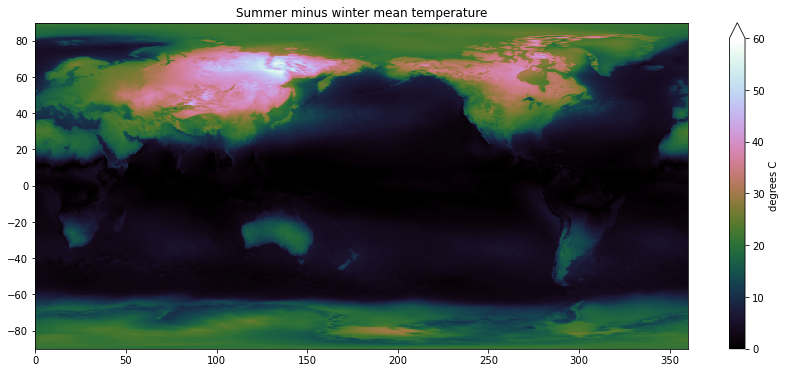

In [14]:
plt.figure(figsize=(15, 6))
plt.imshow(result, cmap='cubehelix', vmin=0, vmax=60,
           extent=[0, 360, -90, 90], interpolation='nearest')
plt.title('Summer minus winter mean temperature')
plt.colorbar(label='degrees C', extend='max');

In [14]:
%%time

stacked_ds  = ds.stack(gridcell=['latitude', 'longitude'])
group = stacked_ds.groupby('gridcell').min()

CPU times: user 8.44 s, sys: 668 ms, total: 9.11 s
Wall time: 8.93 s


In [17]:
ds.min(dim='time')

,Array,Chunk
Bytes,4.15 MB,400 B
Shape,"(721, 1440)","(10, 10)"
Count,31537 Tasks,10512 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.15 MB,400 B
Shape,"(721, 1440)","(10, 10)"
Count,31537 Tasks,10512 Chunks
Type,float32,numpy.ndarray


In [92]:
%%time
#This took way to long
# min_temps = group.min(dim='gridcell')

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 17.6 µs


In [15]:
stacked_ds

,Array,Chunk
Bytes,49.84 MB,69.12 kB
Shape,"(12, 1038240)","(12, 1440)"
Count,12748 Tasks,721 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,49.84 MB,69.12 kB
Shape,"(12, 1038240)","(12, 1440)"
Count,12748 Tasks,721 Chunks
Type,float32,numpy.ndarray


In [ ]:
stacked = da.stack(gridcell=["ny", "nx"])
stacked.groupby("gridcell").sum(...).unstack("gridcell")

In [10]:
with ProgressBar():
    stacked_ds  = ds.stack(gridcell=['latitude', 'longitude'])
    group = stacked_ds.groupby('gridcell')
    group.compute()

AttributeError: 'DatasetGroupBy' object has no attribute 'compute'